In [1]:
from tensorflow.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import tensorflow as tf

from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#!pip install pydotplus
#!pip install pydot
#!conda install graphviz

# Metadata

In [3]:
# Read Data
merge_cases_temp_precip = pd.read_csv('../Data/Dataset_Medellin/merge_cases_WeeklyTemperature_WeeklyPrecipitation_timeseries.csv')
# Remove extra column
merge_cases_temp_precip.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
merge_cases_temp_precip.rename(columns={'temperature':'temperature_medellin'}, inplace=True)
merge_cases_temp_precip.LastDayWeek = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
merge_cases_temp_precip

,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek,MONTH,percipitation_medellin,percipitation_medellin_rural,percipitation_medellin_urbano,temperature_medellin
0,1,"['2007', 'w01']",2007,200701,2007-01-06,1,13.096688,14.097693,12.628933,19.615357
1,0,"['2007', 'w02']",2007,200702,2007-01-13,1,8.437044,6.910390,9.067214,22.234000
2,0,"['2007', 'w03']",2007,200703,2007-01-20,1,19.373165,21.616968,18.406665,22.268857
3,0,"['2007', 'w04']",2007,200704,2007-01-27,1,0.000000,0.000000,0.000000,23.546000
4,0,"['2007', 'w05']",2007,200705,2007-02-03,2,3.725206,3.144225,3.901021,25.353071
...,...,...,...,...,...,...,...,...,...,...
619,28,"['2018', 'w48']",2018,201848,2018-12-01,12,8.916642,8.656351,9.114419,21.436857
620,12,"['2018', 'w49']",2018,201849,2018-12-08,12,17.006086,16.076869,17.334870,22.156286
621,27,"['2018', 'w50']",2018,201850,2018-12-15,12,5.673248,5.388778,5.794555,17.271000
622,17,"['2018', 'w51']",2018,201851,2018-12-22,12,2.785103,2.708024,2.810241,19.071071


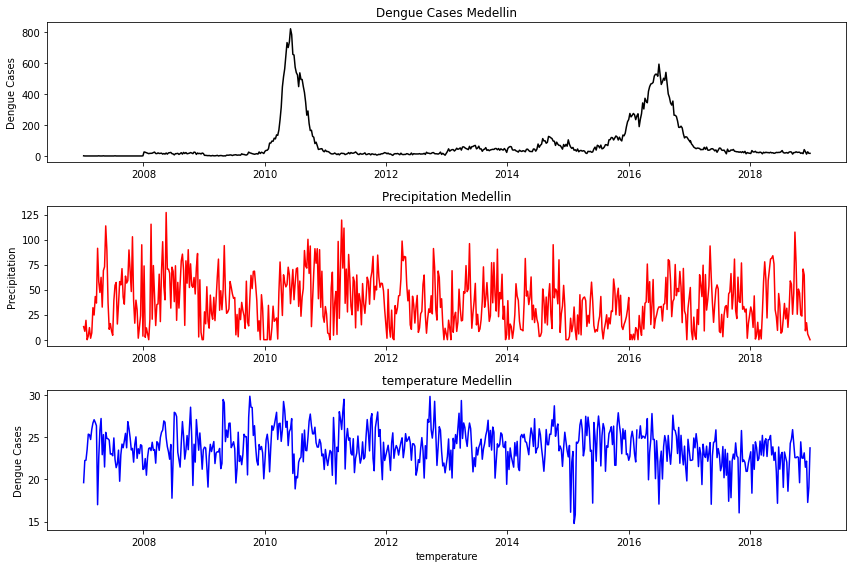

In [4]:
f, axarr = plt.subplots(3, 1, figsize=(12, 8))


axarr[0].plot(merge_cases_temp_precip['LastDayWeek'], merge_cases_temp_precip['cases_medellin'], color ='black')
axarr[0].set_title('Dengue Cases Medellin')
axarr[0].set_ylabel('Dengue Cases')
plt.tight_layout()

axarr[1].plot(merge_cases_temp_precip['LastDayWeek'], merge_cases_temp_precip['percipitation_medellin'], color ='red')
axarr[1].set_title('Precipitation Medellin')
axarr[1].set_ylabel('Precipitation')
plt.tight_layout()

axarr[2].plot(merge_cases_temp_precip['LastDayWeek'], merge_cases_temp_precip['temperature_medellin'], color ='blue')
axarr[2].set_title('temperature Medellin')
axarr[2].set_xlabel('temperature') 
axarr[2].set_ylabel('Dengue Cases')
plt.tight_layout()


plt.show()

### Select features (temp, prec, cases)

In [5]:
dataset = merge_cases_temp_precip[['temperature_medellin','percipitation_medellin','cases_medellin']]
dataset.index = merge_cases_temp_precip.LastDayWeek
dataset  #DF

,temperature_medellin,percipitation_medellin,cases_medellin
LastDayWeek,,,
2007-01-06,19.615357,13.096688,1
2007-01-13,22.234000,8.437044,0
2007-01-20,22.268857,19.373165,0
2007-01-27,23.546000,0.000000,0
2007-02-03,25.353071,3.725206,0
...,...,...,...
2018-12-01,21.436857,8.916642,28
2018-12-08,22.156286,17.006086,12
2018-12-15,17.271000,5.673248,27


# Prepare data to supervised learning time series

we will use:
* data: is the dataframe in our case (Dengue Cases, Precipitation and Temperature)
* n_in: is the number of lag weeks in the past (length of window)

The heart of this "series_to_supervised" function is the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html">shift</a> fuction of pandas

This function gets as input the number of periods(in this case the number of weeks represented as rows up or down in the dataframe) to move the columns of a dataframe.
E.g. 
* If we have merge_cases_temp_precip['cases_medellin'].shift(1) all the rows of column cases_medellin will move one row down
* If we have merge_cases_temp_precip['cases_medellin'].shift(-1) all the rows of column cases_medellin will move one row up



In [6]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

### normalize features
As we are working with a Neural Network the data values ​​must be normalized to help backpropagation algorithm
So we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a> from sklearn

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaler between 0 and 1
scaled = scaler.fit_transform(dataset) # As we can see data set has 3 Columns (This shape is also important for inverse scaler as we will see in future)

In [8]:
# length of window
weeks = 7

# frame as supervised learning
data = series_to_supervised(scaled, n_in=weeks)
DataFrame(data).head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
7,0.320885,0.103033,0.00122,0.494782,0.066375,0.0,0.497097,0.152411,0.0,0.581909,...,0.0,0.697818,0.095100,0.0,0.659809,0.011560,0.0,0.740010,0.053504,0.0
8,0.494782,0.066375,0.00000,0.497097,0.152411,0.0,0.581909,0.000000,0.0,0.701912,...,0.0,0.659809,0.011560,0.0,0.740010,0.053504,0.0,0.789821,0.251632,0.0
9,0.497097,0.152411,0.00000,0.581909,0.000000,0.0,0.701912,0.029307,0.0,0.697818,...,0.0,0.740010,0.053504,0.0,0.789821,0.251632,0.0,0.815364,0.194133,0.0
10,0.581909,0.000000,0.00000,0.701912,0.029307,0.0,0.697818,0.095100,0.0,0.659809,...,0.0,0.789821,0.251632,0.0,0.815364,0.194133,0.0,0.794574,0.339599,0.0
11,0.701912,0.029307,0.00000,0.697818,0.095100,0.0,0.659809,0.011560,0.0,0.740010,...,0.0,0.815364,0.194133,0.0,0.794574,0.339599,0.0,0.768328,0.287922,0.0


## change the regression task to classification

In [9]:
# We define the number of features as 3 (Temperature, Precipitation and Dengue Cases)
n_features = 3
# The features to train the model will be all except the values of the actual week 
# We can't use the temperature and precipitation in week t because whe need to resample a a 3D Array
features_set = DataFrame(data.values[:,:-n_features])
# Convert pandas data frame to np.array to reshape as 3D Array
features_set = features_set.to_numpy()
features_set

array([[0.32088512, 0.10303316, 0.00121951, ..., 0.65980932, 0.01156009,
        0.        ],
       [0.49478228, 0.0663752 , 0.        , ..., 0.74001044, 0.05350439,
        0.        ],
       [0.49709705, 0.15241093, 0.        , ..., 0.7898207 , 0.25163208,
        0.        ],
       ...,
       [0.32027322, 0.36671493, 0.02926829, ..., 0.48962148, 0.13378884,
        0.01463415],
       [0.64135281, 0.19467965, 0.02073171, ..., 0.16520254, 0.0446321 ,
        0.03292683],
       [0.5146618 , 0.18568342, 0.02439024, ..., 0.28474054, 0.02191073,
        0.02073171]])

## Labels Set

In [10]:
# Compare dengue cases in the future week and in the actual week
labels_comparation = DataFrame(data.values[:,-1]) - DataFrame(data.values[:,-4])


labels_set = []
for label in labels_comparation.values:    
    if label > 0:
        labels_set.append('increase')
    if label < 0:
        labels_set.append('decreased')
    if label == 0:
        labels_set.append('same')


In [11]:
# Convert pandas data frame to np.array
labels_set = np.array(labels_set)
print(f'{labels_set[0:5]}...')

['same' 'same' 'same' 'same' 'same']...


In [12]:
labels_set = pd.get_dummies(labels_set)

### Train-test split

In [13]:
# We need a sequence so we can't split randomly
# To divide into Train (90%) and test (10%) to do that we need to know the 90% of the total dataframe
size = features_set.shape[0]
split = int(size*(9/10))

### Train

In [14]:
# We will train with 1st 90% of data and test with last 10%
train_X = features_set[:split] ##90% train
train_y = labels_set[:split]  ##90% train

### Test

In [15]:
test_X = features_set[split:] ##10% test
test_y = labels_set[split:] ##10% test

In [16]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(548, 7, 3) (548, 3) (61, 7, 3) (61, 3)


## LSTM

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=40, 
        verbose=1, mode='auto', restore_best_weights=True)

In [18]:
# Set Seed
tf.random.set_seed(1)
def generate_model_lstm(timesteps=train_X.shape[1], columns=train_X.shape[2]):
    
    ip = Input(shape=(timesteps, columns))
    
    # design network
    x = Masking()(ip)
    x = LSTM(30, input_shape=(timesteps, columns), return_sequences = True)(x)
    x = LSTM(15, input_shape=(timesteps, 30))(x)
    
    x = Dense(7) (x)

    x = Dropout(0.2)(x)
    out = Dense(3, activation='softmax')(x)
    
    model = Model(ip, out)
    model.summary()
    
    return model
    

model = generate_model_lstm(timesteps=train_X.shape[1], columns=train_X.shape[2])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.003), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 3)]            0         
_________________________________________________________________
masking (Masking)            (None, 7, 3)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 30)             4080      
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                2760      
_________________________________________________________________
dense (Dense)                (None, 7)                 112       
_________________________________________________________________
dropout (Dropout)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 24    

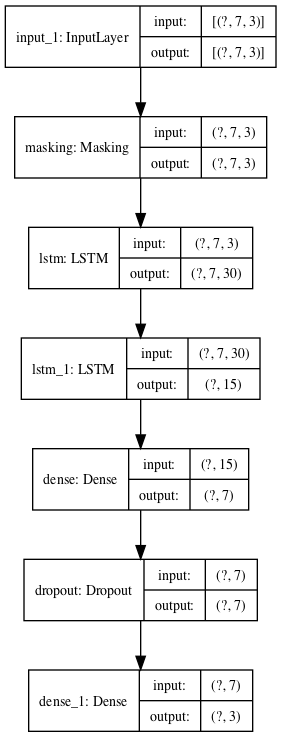

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
train_y.values

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [21]:
train_y.sum()

decreased    249
increase     230
same          69
dtype: int64

In [22]:
positive_weights = {}
negative_weights = {}

for i, c in enumerate(train_y.columns):
    positive_weights[i] = train_y.shape[0]/(2*np.count_nonzero(train_y[c]==1))
    negative_weights[i] = train_y.shape[0]/(2*np.count_nonzero(train_y[c]==0))
print(positive_weights)
print('----------------------')
print(negative_weights)

{0: 1.1004016064257027, 1: 1.191304347826087, 2: 3.971014492753623}
----------------------
{0: 0.9163879598662207, 1: 0.8616352201257862, 2: 0.5720250521920668}


In [23]:
# fit network
tf.random.set_seed(1)

history = model.fit(train_X, train_y.values, epochs=1000, batch_size=256, validation_data=(test_X, test_y.values), verbose=2, shuffle=True, callbacks=[monitor], class_weight=positive_weights)

Train on 548 samples, validate on 61 samples
Epoch 1/1000
548/548 - 9s - loss: 1.6488 - accuracy: 0.3850 - val_loss: 1.5627 - val_accuracy: 0.4426
Epoch 2/1000
548/548 - 0s - loss: 1.6453 - accuracy: 0.3741 - val_loss: 1.5639 - val_accuracy: 0.3443
Epoch 3/1000
548/548 - 0s - loss: 1.6407 - accuracy: 0.3814 - val_loss: 1.5627 - val_accuracy: 0.4098
Epoch 4/1000
548/548 - 0s - loss: 1.6351 - accuracy: 0.4234 - val_loss: 1.5586 - val_accuracy: 0.4426
Epoch 5/1000
548/548 - 0s - loss: 1.6366 - accuracy: 0.4325 - val_loss: 1.5555 - val_accuracy: 0.4426
Epoch 6/1000
548/548 - 0s - loss: 1.6387 - accuracy: 0.4434 - val_loss: 1.5575 - val_accuracy: 0.4426
Epoch 7/1000
548/548 - 0s - loss: 1.6278 - accuracy: 0.4270 - val_loss: 1.5648 - val_accuracy: 0.3770
Epoch 8/1000
548/548 - 0s - loss: 1.6232 - accuracy: 0.3558 - val_loss: 1.5726 - val_accuracy: 0.1803
Epoch 9/1000
548/548 - 0s - loss: 1.6172 - accuracy: 0.3157 - val_loss: 1.5728 - val_accuracy: 0.1639
Epoch 10/1000
548/548 - 0s - loss: 1.

Epoch 81/1000
548/548 - 0s - loss: 1.3793 - accuracy: 0.4124 - val_loss: 1.5496 - val_accuracy: 0.4590
Epoch 82/1000
548/548 - 0s - loss: 1.3302 - accuracy: 0.4745 - val_loss: 1.5720 - val_accuracy: 0.4098
Epoch 83/1000
Restoring model weights from the end of the best epoch.
548/548 - 0s - loss: 1.3333 - accuracy: 0.4690 - val_loss: 1.5266 - val_accuracy: 0.3934
Epoch 00083: early stopping


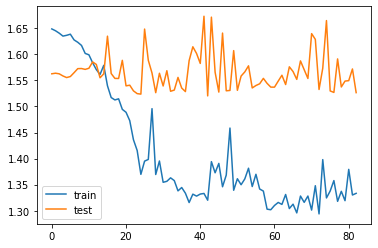

In [24]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
from math import sqrt

# make a prediction
yhat = model.predict(test_X)

In [26]:
yhat= yhat
yhat

array([[0.4421049 , 0.44248512, 0.11540997],
       [0.45360565, 0.45116255, 0.09523179],
       [0.44984308, 0.44813576, 0.10202114],
       [0.41889128, 0.43084177, 0.15026699],
       [0.40964165, 0.42811236, 0.16224599],
       [0.36459577, 0.39269045, 0.24271381],
       [0.3196521 , 0.35344145, 0.32690644],
       [0.2820099 , 0.3219447 , 0.39604542],
       [0.38721928, 0.4167549 , 0.19602586],
       [0.38526404, 0.41666707, 0.1980689 ],
       [0.3623563 , 0.40147245, 0.23617132],
       [0.32936364, 0.3736561 , 0.2969802 ],
       [0.32984903, 0.37494233, 0.29520866],
       [0.25403062, 0.3038178 , 0.44215167],
       [0.31893742, 0.36791036, 0.3131522 ],
       [0.3331518 , 0.3812968 , 0.2855514 ],
       [0.36411   , 0.40759838, 0.22829172],
       [0.39752114, 0.43267828, 0.16980053],
       [0.40232542, 0.44104475, 0.15662982],
       [0.39090005, 0.43386614, 0.17523387],
       [0.4007048 , 0.44445562, 0.15483963],
       [0.3679812 , 0.4210149 , 0.21100387],
       [0.

In [27]:
predic = []
for i in range(len(yhat)):
    predic.append(np.argmax(yhat[i,:]))

y_pred = pd.get_dummies(predic)

"""
if y_pred.shape[1] == 2:
    y_pred['1'] = 0
    y_pred = y_pred[[0, '1', 2]]
"""

y_pred.shape

(61, 3)

In [28]:
test_y.shape

(61, 3)

In [29]:
test_y

,decreased,increase,same
548,1,0,0
549,0,1,0
550,1,0,0
551,0,1,0
552,1,0,0
...,...,...,...
604,1,0,0
605,1,0,0
606,0,1,0
607,1,0,0


In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def test_model(y_test=test_y, y_pred=y_pred.values):


    print("---------------------- Evaluation ----------------------")

    print(f'El  accuracy es: {accuracy_score(y_test, y_pred)}')
    print(f"La precision es: {precision_score(y_test, y_pred, average='macro')}")
    print(f"El recall es: {recall_score(y_test, y_pred, average='macro')}")
    print(f"El f1 score es: {f1_score(y_test, y_pred, average='macro')}")

    print('')
    print('Confusion matrix:')
    print("")    
    
    matrix = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
    # Mostrar la Matriz de confusión
    
    
    plt.figure(figsize=(15, 8))
    # Mostrar gráfica como mapa de calor con valores
    sns.heatmap(matrix, annot=True)
    plt.show()
    print("---------------------- Evaluation ----------------------")
    print("")

---------------------- Evaluation ----------------------
El  accuracy es: 0.36065573770491804
La precision es: 0.35697399527186763
El recall es: 0.3575837742504409
El f1 score es: 0.26746746746746747

Confusion matrix:



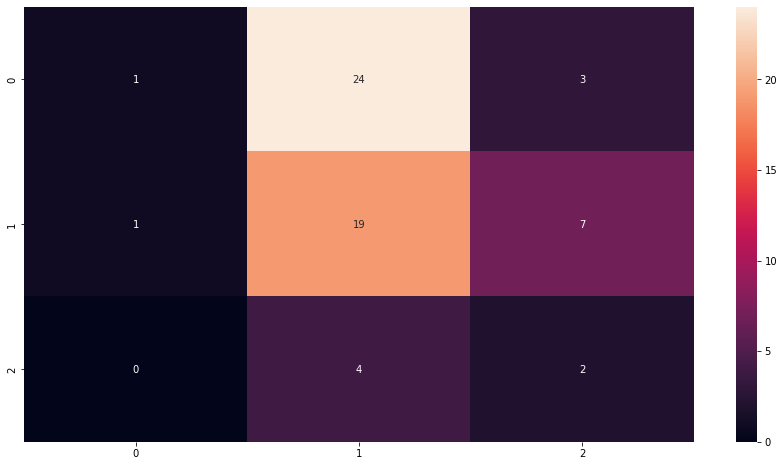

---------------------- Evaluation ----------------------



In [31]:
test_model()

# LSTM + FCN

In [32]:
# model: https://github.com/houshd/MLSTM-FCN/blob/master/ck_model.py
# lstm documentation: https://keras.io/api/layers/recurrent_layers/lstm/

def generate_model_3(timesteps, columns):
    
    ip = Input(shape=(timesteps, columns))

    x = Masking()(ip)
    x = LSTM(8)(x)
    x = Dropout(0.2)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    #y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    #y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(3, activation='softmax')(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

In [33]:
model = generate_model_3(timesteps=train_X.shape[1], columns=train_X.shape[2])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.003), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 3)]       0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 3, 7)         0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3, 128)       7296        permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3, 128)       512         conv1d[0][0]                     
____________________________________________________________________________________________

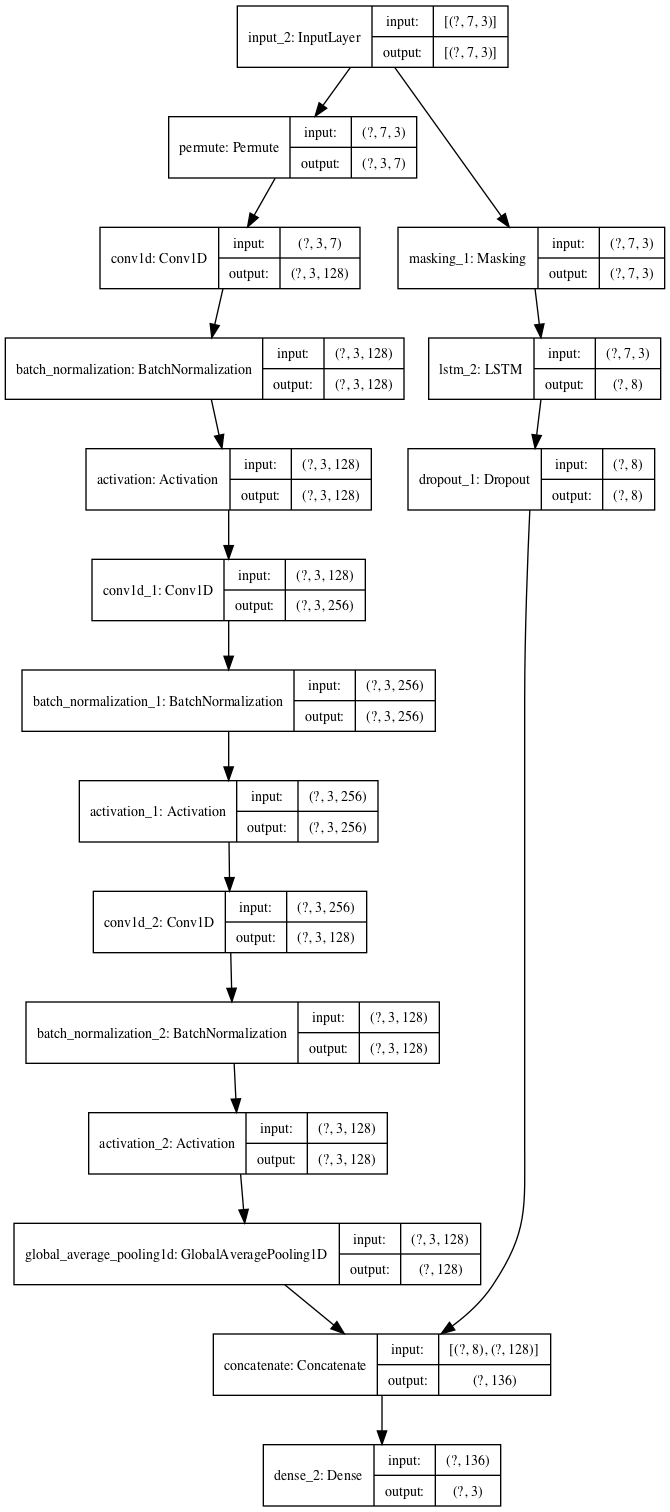

In [34]:
plot_model(model,show_shapes=True, show_layer_names=True)

In [35]:
# fit network
tf.random.set_seed(1)
history = model.fit(train_X, train_y.values, epochs=1000, batch_size=256, validation_data=(test_X, test_y.values), verbose=2, shuffle=True, callbacks=[monitor], class_weight=positive_weights)

Train on 548 samples, validate on 61 samples
Epoch 1/1000
548/548 - 6s - loss: 2.0705 - accuracy: 0.3814 - val_loss: 1.6165 - val_accuracy: 0.4590
Epoch 2/1000
548/548 - 0s - loss: 1.5888 - accuracy: 0.3996 - val_loss: 1.5894 - val_accuracy: 0.4754
Epoch 3/1000
548/548 - 0s - loss: 1.4377 - accuracy: 0.4726 - val_loss: 1.5528 - val_accuracy: 0.4754
Epoch 4/1000
548/548 - 0s - loss: 1.4197 - accuracy: 0.4891 - val_loss: 1.5731 - val_accuracy: 0.2951
Epoch 5/1000
548/548 - 0s - loss: 1.3831 - accuracy: 0.5055 - val_loss: 1.5738 - val_accuracy: 0.3279
Epoch 6/1000
548/548 - 0s - loss: 1.3011 - accuracy: 0.5675 - val_loss: 1.5523 - val_accuracy: 0.4918
Epoch 7/1000
548/548 - 0s - loss: 1.2419 - accuracy: 0.5839 - val_loss: 1.5831 - val_accuracy: 0.4754
Epoch 8/1000
548/548 - 0s - loss: 1.2842 - accuracy: 0.4945 - val_loss: 1.5761 - val_accuracy: 0.4590
Epoch 9/1000
548/548 - 0s - loss: 1.1900 - accuracy: 0.5620 - val_loss: 1.5491 - val_accuracy: 0.4262
Epoch 10/1000
548/548 - 0s - loss: 1.

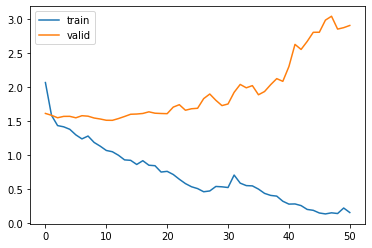

In [36]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

In [37]:
# make a prediction
yhat = model.predict(test_X)
predic = []
for i in range(len(yhat)):
    predic.append(np.argmax(yhat[i,:]))

y_pred = pd.get_dummies(predic)


if y_pred.shape[1] == 2:
    y_pred['1'] = 0
    y_pred = y_pred[[0, '1', 2]]
    
y_pred.shape

(61, 3)

---------------------- Evaluation ----------------------
El  accuracy es: 0.36065573770491804
La precision es: 0.35697399527186763
El recall es: 0.3575837742504409
El f1 score es: 0.26746746746746747

Confusion matrix:



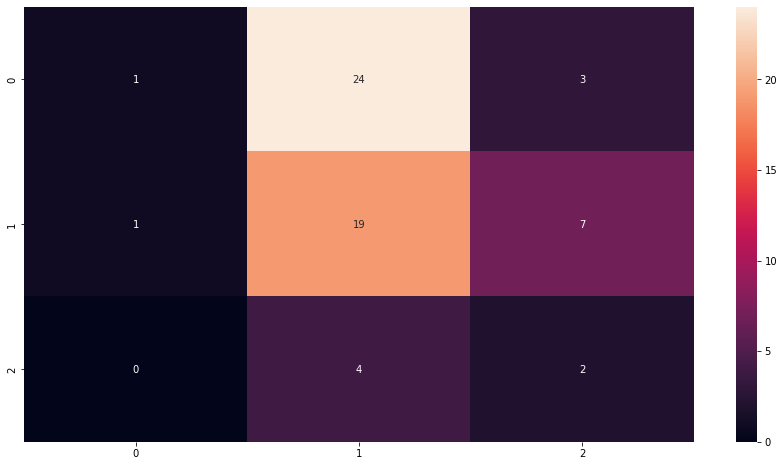

---------------------- Evaluation ----------------------



In [38]:
test_model()

### Read Image

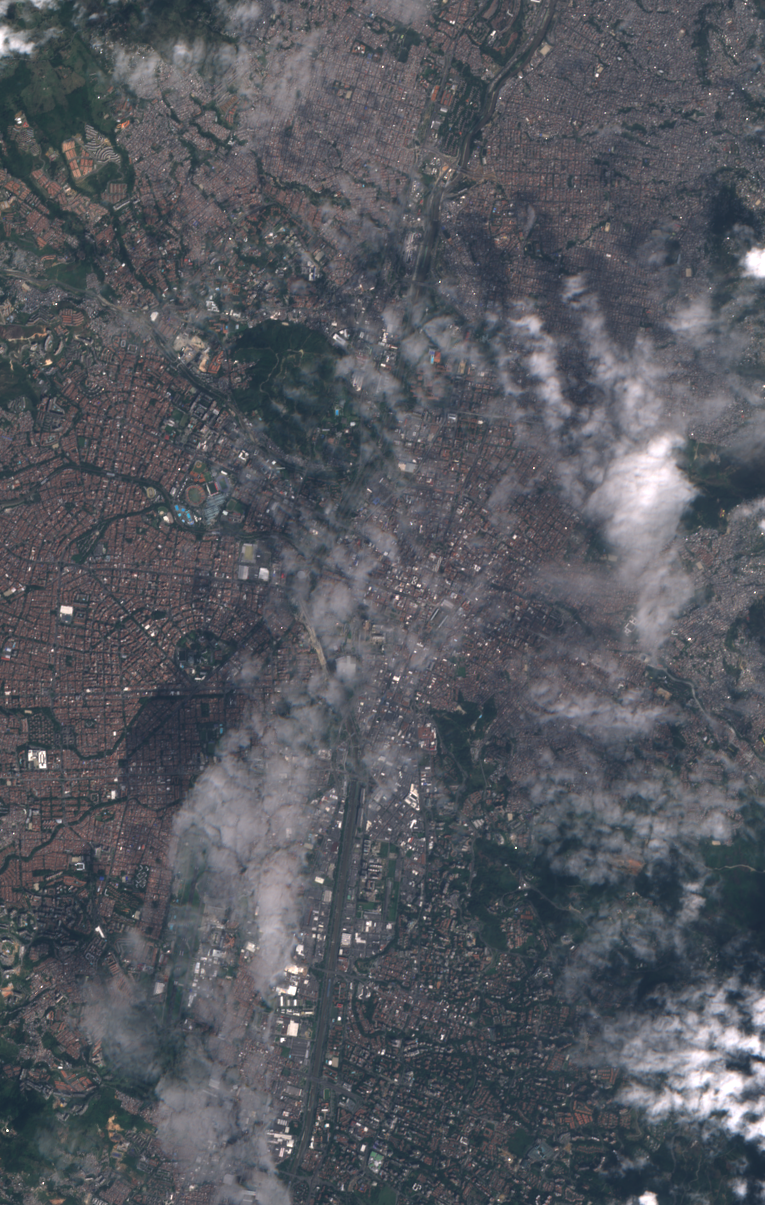

In [42]:
from PIL import Image
Image.open('../Data/dataset_rbg/image_2016-01-10.tiff')

In [52]:
from skimage import io
im = io.imread('../Data/data_7_bands/image_2016-01-03.tiff')
im.shape

(1205, 765, 7)